In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
# warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")


### Load the dataset

In [2]:
df = pd.read_csv("../data/children_anemia_cleaned.csv")

### Preparing the data

In [3]:


X = df.drop('anemia_level', axis=1)
y = df['anemia_level']

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73939133)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Algorithm 1 : KNN

In [4]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred)
knn_rep = classification_report(y_test, y_pred)

print(f"KNN Accuracy on Test Set: {accuracy_knn}")
print(f"\nKNN Classification Report:\n {knn_rep}")

KNN Accuracy on Test Set: 0.6113022113022113

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.18      0.24        22
           1       0.67      0.80      0.73       857
           2       0.41      0.42      0.41       535
           3       0.71      0.55      0.62       591
           4       0.75      0.10      0.18        30

    accuracy                           0.61      2035
   macro avg       0.58      0.41      0.44      2035
weighted avg       0.61      0.61      0.60      2035



#### Train/Tune model

In [5]:
# Defining a range of K values to explore
k_values = range(2, 41)

# Store all the average cross-validation scores for each value of K
err_rates = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform 6-fold cross-validation and store the mean accuracy
    # scores = cross_val_score(knn, X_train_scaled, y_train, cv=6, scoring='roc_auc_ovr')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=4)
    # scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    # err_rates.append(scores.mean())
    err_rates.append(1 - scores.mean())

# Find the K value that maximizes the cross-validation score or minimizes the error rate
# best_k = k_values[np.argmax(err_rates)]
best_k = k_values[np.argmin(err_rates)]
# best_score = max(err_rates)
best_score = min(err_rates)

print(f"Best k value is : {best_k}")
# print(f"Accuracy with best k is : {best_score}")
print(f"Error rate with best k is : {best_score}")

Best k value is : 40
Error rate with best k is : 0.39687807276302856


In [6]:
# Visualize with elbow method
# print(err_rates)
# plt.figure(figsize=(16, 10))
# plt.xticks(k_values)
# plt.plot(k_values, err_rates)

In [7]:
# Retrain the KNN model with the identified optimal K
optim_knn = KNeighborsClassifier(n_neighbors=best_k)
optim_knn.fit(X_train_scaled, y_train)
ypred_optim_knn = optim_knn.predict(X_test_scaled)

knn_best_acc = accuracy_score(y_test, ypred_optim_knn)
knn_best_rprt = classification_report(y_test, ypred_optim_knn, zero_division=0)

# print(f"Optimal K: {best_k} with Cross-Validation Score: {best_score}\n")
print(f"Optimal K={best_k} with least error rate : {best_score}\n")
print(f"KNN Accuracy on test dataset : {knn_best_acc}")
print(f"\nKNN Classification Report:\n {knn_best_rprt}")

Optimal K=40 with least error rate : 0.39687807276302856

KNN Accuracy on test dataset : 0.6186732186732187

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.65      0.88      0.75       857
           2       0.41      0.28      0.34       535
           3       0.70      0.60      0.65       591
           4       0.00      0.00      0.00        30

    accuracy                           0.62      2035
   macro avg       0.35      0.35      0.35      2035
weighted avg       0.58      0.62      0.59      2035



### Algorithm 2: Naive Bayes

In [8]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train)
ypred_gnb = gnb_model.predict(X_test_scaled)

gnb_acc = accuracy_score(y_test, ypred_gnb)
report_gnb = classification_report(y_test, ypred_gnb)

print(f"Naive Bayes (default) Model Accuracy on Test Set: {gnb_acc}")
print(f"\nNaive Bayes Model Classification Report:\n {report_gnb}")

Naive Bayes (default) Model Accuracy on Test Set: 0.30073710073710075

Naive Bayes Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.98      0.18      0.30       857
           2       0.40      0.76      0.52       535
           3       0.28      0.01      0.02       591
           4       0.04      0.97      0.07        30

    accuracy                           0.30      2035
   macro avg       0.54      0.58      0.38      2035
weighted avg       0.61      0.30      0.28      2035



#### Train/Tune model

In [9]:
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=300)
}

gnb = GaussianNB()
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'var_smoothing': 0.005923457145875806}, 0.6269669233406172)

In [10]:
# Re-train the model with the optimized parameter
optim_gnb = GaussianNB(var_smoothing=best_params['var_smoothing'])
optim_gnb.fit(X_train_scaled, y_train)

ypred_optim_gnb = optim_gnb.predict(X_test_scaled)

acc_optim_gnb = accuracy_score(y_test, ypred_optim_gnb)
report_optimized_gnb = classification_report(y_test, ypred_optim_gnb)

print(f"Optimiized Naive Bayes Model Accuracy on Test Set: {acc_optim_gnb}")
print(f"\nOptimized Naive Bayes Model Classification Report:\n {report_optimized_gnb}")

Optimiized Naive Bayes Model Accuracy on Test Set: 0.65995085995086

Optimized Naive Bayes Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.96      0.64      0.77       857
           2       0.48      0.92      0.63       535
           3       0.92      0.42      0.58       591
           4       0.20      0.93      0.32        30

    accuracy                           0.66      2035
   macro avg       0.71      0.78      0.66      2035
weighted avg       0.81      0.66      0.67      2035



### Algorithm 3: Logistic Regression

In [11]:
logreg = LogisticRegression(max_iter=100)
logreg.fit(X_train_scaled, y_train)
ypred_logreg = logreg.predict(X_test_scaled)
acc_logreg = accuracy_score(y_test, ypred_logreg)
report_logreg = classification_report(y_test, ypred_logreg,zero_division=0)

print(f"Logistic Regression Model accuracy on test set: {acc_logreg}")
print(f"\nLogistic Regression Model classification report:\n {report_logreg}")

Logistic Regression Model accuracy on test set: 0.8653562653562653

Logistic Regression Model classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.93      0.93      0.93       857
           2       0.73      0.79      0.76       535
           3       0.90      0.87      0.88       591
           4       0.96      0.80      0.87        30

    accuracy                           0.87      2035
   macro avg       0.70      0.68      0.69      2035
weighted avg       0.86      0.87      0.86      2035



#### Train/Tune model

In [12]:
# Adjust the hyperparameter grid and cross-validation strategy
param_grid_adjusted = {
    'C': np.logspace(-3, 3, 20),
    'penalty': ["l2"],
    'solver': ["lbfgs", "saga"]
}

gridsrch_lr_adj = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_adjusted, cv=3, scoring='accuracy', verbose=1)
gridsrch_lr_adj.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
lr_bestparams = gridsrch_lr_adj.best_params_
lr_tuned_score = gridsrch_lr_adj.best_score_

print(f"Best adjusted params for logistic regression : {lr_bestparams}")
print(f"Best score for the tuned hyperparameters : {lr_tuned_score}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best adjusted params for logistic regression : {'C': 112.88378916846884, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score for the tuned hyperparameters : 0.8617256637168141


In [13]:
# Retrain the model with the optimized hyperparameters
optim_logreg = LogisticRegression(max_iter=1000, C=lr_bestparams['C'], penalty='l2', solver='lbfgs')
optim_logreg.fit(X_train_scaled, y_train)

ypred_optim_logreg = optim_logreg.predict(X_test_scaled)

acc_optim_logreg = accuracy_score(y_test, ypred_optim_logreg)
rport_optim_logreg = classification_report(y_test, ypred_optim_logreg, zero_division=0)

print(f"Optimized Logistic Regression model accuracy on test set : {acc_optim_logreg}")
print(f"\nOptimized Logistic Regression Model classification report :\n {rport_optim_logreg}")


Optimized Logistic Regression model accuracy on test set : 0.8658476658476658

Optimized Logistic Regression Model classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.94      0.93      0.94       857
           2       0.73      0.80      0.76       535
           3       0.90      0.86      0.88       591
           4       0.89      0.83      0.86        30

    accuracy                           0.87      2035
   macro avg       0.69      0.69      0.69      2035
weighted avg       0.86      0.87      0.86      2035



### Algorithm 4: SVM(Support vector machines)

In [14]:
linear_svm = SVC(kernel='linear', C=1)
linear_svm.fit(X_train_scaled, y_train)

ypred_svm = linear_svm.predict(X_test_scaled)
linsvm_acc = accuracy_score(y_test, ypred_svm)
report_svm = classification_report(y_test, ypred_svm, zero_division=0)

print(f"SVM model with linear kernel accuracy on test set : {linsvm_acc}")
print(f"\nSVM model with linear kernel classification report:\n {report_svm}")

SVM model with linear kernel accuracy on test set : 0.88992628992629

SVM model with linear kernel classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.97      0.93      0.95       857
           2       0.77      0.84      0.80       535
           3       0.90      0.91      0.90       591
           4       0.93      0.93      0.93        30

    accuracy                           0.89      2035
   macro avg       0.71      0.72      0.72      2035
weighted avg       0.88      0.89      0.89      2035



#### Train/Tune model

In [15]:
# Adjust the parameter exploration to a smaller set using continuous range for C
param_dist_svm_linear = {
    'C': loguniform(1e-1, 1e2),
    'kernel': ['linear', 'rbf']
}

rand_search_svm = RandomizedSearchCV(SVC(), param_distributions=param_dist_svm_linear, n_iter=10, cv=3, scoring='accuracy', verbose=1, random_state=73939133)
rand_search_svm.fit(X_train_scaled, y_train)

best_params_svm = rand_search_svm.best_params_
best_score_svm = rand_search_svm.best_score_

print(f"Best parameters for SVM model : {best_params_svm}")
print(f"best score achieved with tuned SVM model : {best_score_svm}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for SVM model : {'C': 5.03065037324288, 'kernel': 'linear'}
best score achieved with tuned SVM model : 0.8812684365781712


In [16]:
# Load the SVM model with the best kernel and best C param
optimized_svm = SVC(kernel=best_params_svm['kernel'] , C=best_params_svm['C'])

optimized_svm.fit(X_train_scaled, y_train)
y_pred_optimized_svm = optimized_svm.predict(X_test_scaled)

optim_svm_acc = accuracy_score(y_test, y_pred_optimized_svm)
best_svmmodel_report = classification_report(y_test, y_pred_optimized_svm, zero_division=0)

print(f"Optimized SVM model accuracy on test data : {optim_svm_acc}")
print(f"\nOptimized SVM model classification report:\n {best_svmmodel_report}")


Optimized SVM model accuracy on test data : 0.8864864864864865

Optimized SVM model classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.96      0.93      0.95       857
           2       0.77      0.83      0.80       535
           3       0.89      0.91      0.90       591
           4       0.89      0.83      0.86        30

    accuracy                           0.89      2035
   macro avg       0.70      0.70      0.70      2035
weighted avg       0.88      0.89      0.88      2035



### Algorithm 5: Decison Tree

In [17]:
dcsn_tree_tune = DecisionTreeClassifier(random_state=73939133)

dcsn_tree_tune.fit(X_train_scaled, y_train)
ypred_dcsn_tree = dcsn_tree_tune.predict(X_test_scaled)
dcsn_tree_acc = accuracy_score(y_test, ypred_dcsn_tree)
dcsn_tree_report = classification_report(y_test, ypred_dcsn_tree, zero_division=0)

print(f"Decision Tree model accuracy on test data : {dcsn_tree_acc}")
print(f"\nDecision Tree Model Classification Report:\n {dcsn_tree_report}")

Decision Tree model accuracy on test data : 0.8977886977886977

Decision Tree Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.93      0.95      0.94       857
           2       0.82      0.81      0.81       535
           3       0.92      0.90      0.91       591
           4       0.87      0.90      0.89        30

    accuracy                           0.90      2035
   macro avg       0.91      0.91      0.91      2035
weighted avg       0.90      0.90      0.90      2035



#### Train/Tune model

In [18]:
# Define the parameter grid
paramgrid_dcsn_tree = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dcsn_tree_tune = DecisionTreeClassifier(random_state=73939133)
gridsrch_dcsn_tree = GridSearchCV(dcsn_tree_tune, paramgrid_dcsn_tree, cv=3, scoring='accuracy', verbose=1)
gridsrch_dcsn_tree.fit(X_train_scaled, y_train)

best_params_decision_tree = gridsrch_dcsn_tree.best_params_
best_score_decision_tree = gridsrch_dcsn_tree.best_score_

print(f"Best parameters for decision tree model tuning : {best_params_decision_tree}")
print(f"Best accuracy achieved for the tuned decision tree model : {best_score_decision_tree}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters for decision tree model tuning : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy achieved for the tuned decision tree model : 0.9138397246804327


In [19]:
# Initialize the Decision Tree classifier with the best parameters
optim_decision_tree = DecisionTreeClassifier(
    random_state=73939133,
    max_depth=best_params_decision_tree['max_depth'],
    min_samples_split=best_params_decision_tree['min_samples_split'],
    min_samples_leaf=best_params_decision_tree['min_samples_leaf']
)

optim_decision_tree.fit(X_train_scaled, y_train)
ypred_optim_dcsn_tree = optim_decision_tree.predict(X_test_scaled)
acc_optim_dcsn_tree = accuracy_score(y_test, ypred_optim_dcsn_tree)
rep_optim_dcsn_tree = classification_report(y_test, ypred_optim_dcsn_tree, zero_division=0)

print(f"Optimized decision tree model accuracy on test data : {acc_optim_dcsn_tree}")
print(f"\nOptimized Decision Tree Model Classification Report:\n {rep_optim_dcsn_tree}")

Optimized decision tree model accuracy on test data : 0.9233415233415233

Optimized Decision Tree Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.97      0.94      0.95       857
           2       0.87      0.84      0.86       535
           3       0.90      0.98      0.94       591
           4       0.87      0.90      0.89        30

    accuracy                           0.92      2035
   macro avg       0.92      0.93      0.93      2035
weighted avg       0.92      0.92      0.92      2035



### Algorithm 6: Gradient Boosting

In [20]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=73939133)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
report_gbm = classification_report(y_test, y_pred_gbm, zero_division=0)

print(f"Gradient boosting machine model accuracy on test dataset : {accuracy_gbm}")
print(f"\nGradient Boosting Machine Model Classification Report:\n {report_gbm}")

Gradient boosting machine model accuracy on test dataset : 0.9385749385749386

Gradient Boosting Machine Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.93      0.96       857
           2       0.89      0.89      0.89       535
           3       0.91      0.99      0.95       591
           4       0.88      0.93      0.90        30

    accuracy                           0.94      2035
   macro avg       0.93      0.95      0.94      2035
weighted avg       0.94      0.94      0.94      2035



#### Train/Tune model

In [21]:
# Define the parameter distribution
param_dist_gbm = {
    'n_estimators': sp_randint(50, 150),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': sp_randint(3, 6)
}

gbm = GradientBoostingClassifier(random_state=73939133)
random_search_gbm = RandomizedSearchCV(gbm, param_distributions=param_dist_gbm, n_iter=10, cv=3, scoring='accuracy', verbose=1, random_state=73939133)
random_search_gbm.fit(X_train_scaled, y_train)

best_params_gbm = random_search_gbm.best_params_
best_score_gbm = random_search_gbm.best_score_

print(f"Best parameters for gradient boosted model : {best_params_gbm}")
print(f"Best accuracy achieved for gradient boosted model : {best_score_gbm}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for gradient boosted model : {'learning_rate': 0.051120290490909465, 'max_depth': 3, 'n_estimators': 59}
Best accuracy achieved for gradient boosted model : 0.9268682399213373


In [22]:
# Initialize the GBM model with the optimized parameters
optim_gbm = GradientBoostingClassifier(
    n_estimators=best_params_gbm['n_estimators'],
    learning_rate=best_params_gbm['learning_rate'],
    max_depth=best_params_gbm['max_depth'],
    random_state=73939133
)

optim_gbm.fit(X_train_scaled, y_train)
ypred_optim_gbm = optim_gbm.predict(X_test_scaled)

gbm_optim_acc = accuracy_score(y_test, ypred_optim_gbm)
gbm_optim_report = classification_report(y_test, ypred_optim_gbm, zero_division=0)

print(f"Optimized GBM model accuracy on test dataset: {gbm_optim_acc}")
print(f"\nOptimized GBM model classification report:\n {gbm_optim_report}")

Optimized GBM model accuracy on test dataset: 0.9356265356265356

Optimized GBM model classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.93      0.96       857
           2       0.89      0.88      0.88       535
           3       0.90      0.99      0.94       591
           4       0.81      0.97      0.88        30

    accuracy                           0.94      2035
   macro avg       0.92      0.95      0.93      2035
weighted avg       0.94      0.94      0.94      2035



## Model comparison

In [1]:
import matplotlib.pylab as plt

base_dict = {
    "knn" : 0.6113022113022113,
    "naive_bayes" : 0.30073710073710075,
    "logistic_regression" : 0.8653562653562653,
    "svm" : 0.88992628992629,
    "decision_tree" : 0.8977886977886977,
    "gradient_boosting" : 0.9385749385749386,
}

hypertuned_dict = {
    "knn" : 0.6186732186732187,
    "naive_bayes" : 0.65995085995086,
    "logistic_regression" : 0.8658476658476658,
    "svm" : 0.8864864864864865,
    "decision_tree" : 0.9233415233415233,
    "gradient_boosting" : 0.9356265356265356,
}



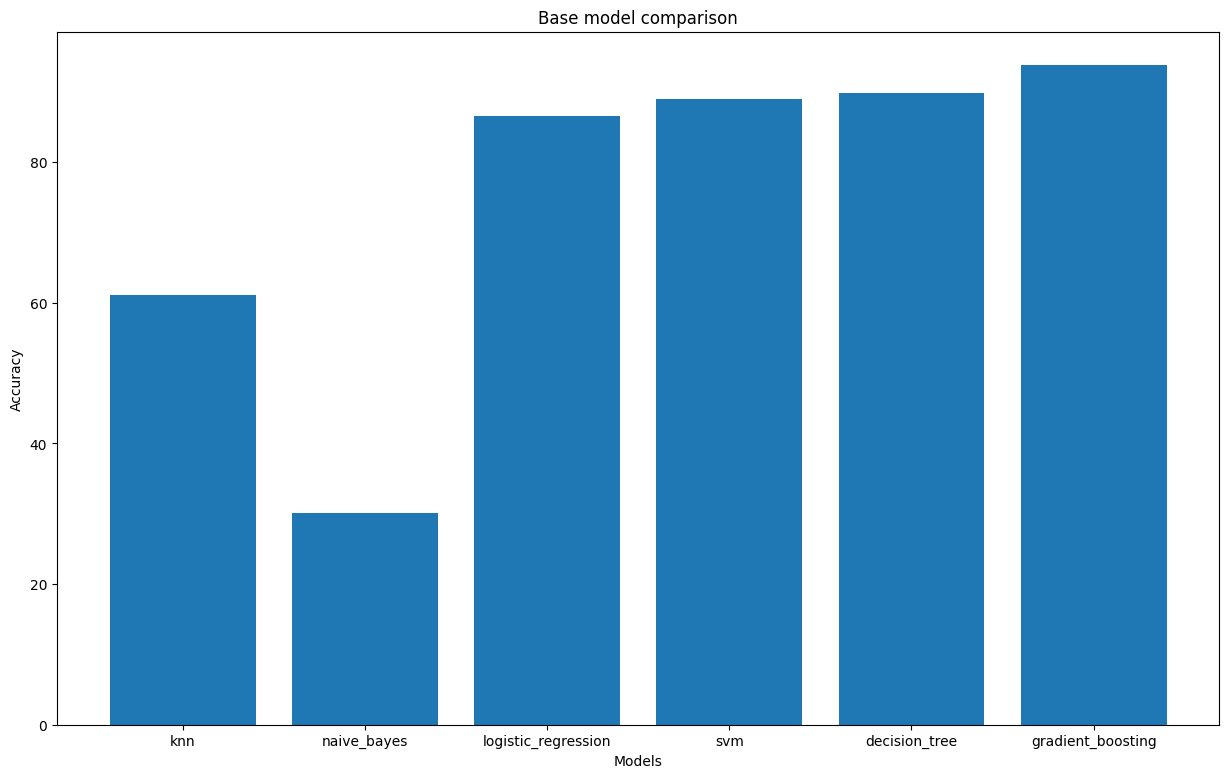

In [10]:
plt.figure(figsize=(15, 9))
plt.bar(range(len(base_dict)), [100*i for i in base_dict.values()], tick_label=list(base_dict.keys()))
plt.savefig('../img/base_comp.png', dpi=240)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Base model comparison')
plt.show()

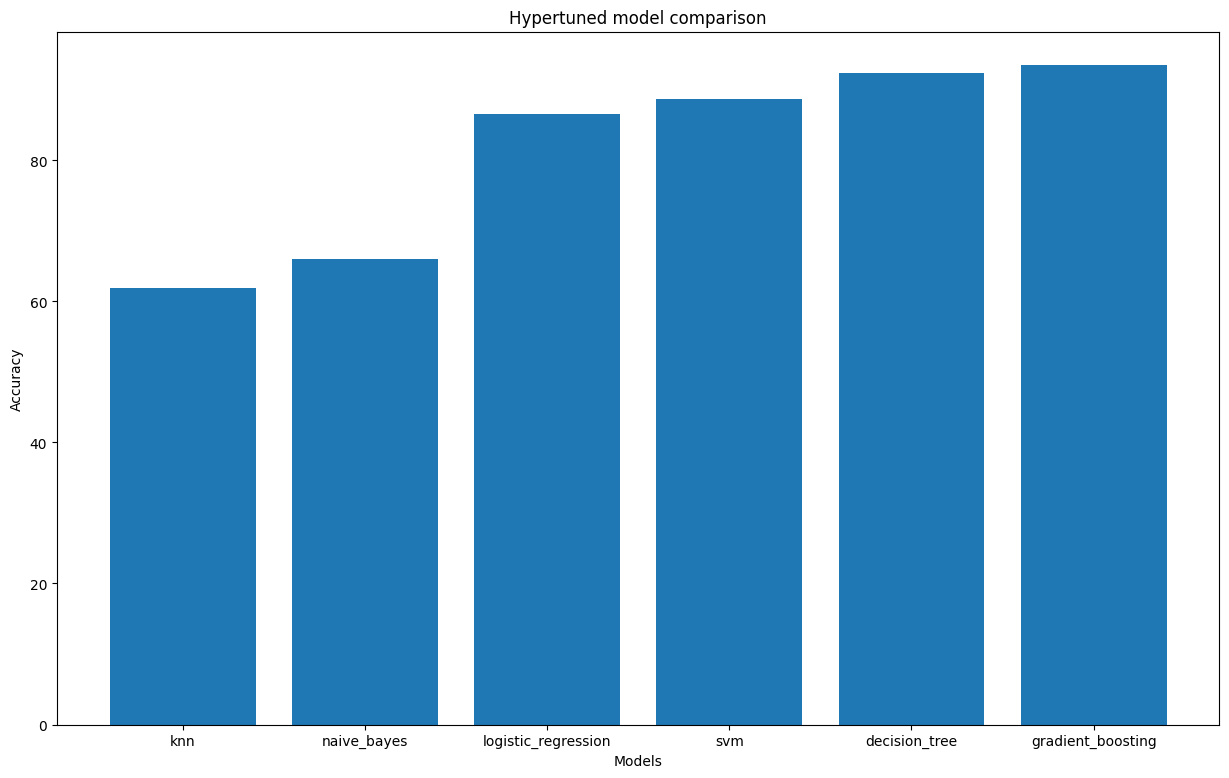

In [11]:
plt.figure(figsize=(15, 9))
plt.bar(range(len(hypertuned_dict)), [100*i for i in hypertuned_dict.values()], tick_label=list(hypertuned_dict.keys()))
plt.savefig('../img/tuned_comp.png', dpi=240)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Hypertuned model comparison')
plt.show()

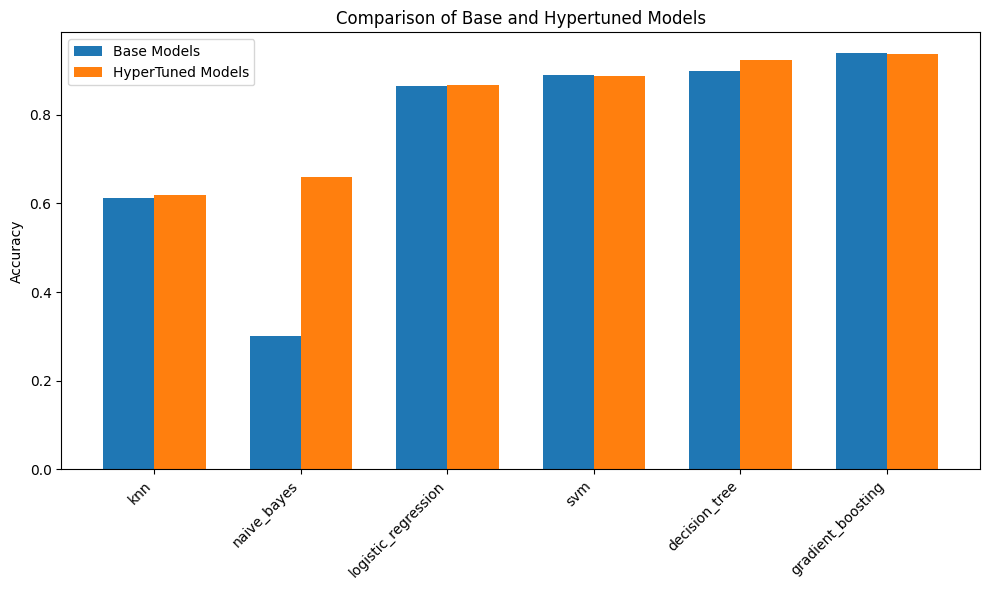

In [12]:
models = list(base_dict.keys())
base_acc = list(base_dict.values())
htuned_acc = list(hypertuned_dict.values())

x = range(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

base_bars = ax.bar([i - width/2 for i in x], base_acc, width, label='Base Models')
htuned_bars = ax.bar([i + width/2 for i in x], htuned_acc, width, label='HyperTuned Models')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Base and Hypertuned Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig('../img/baseVtuned.png', dpi=240)
plt.show()